In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from copy import copy, deepcopy

#np.set_printoptions(precision=4)

In [64]:
def numberToBase(n, b, num_digits):
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b

    while len(digits) < num_digits:
        digits.append(0)
    return digits[::-1]

class RBM:
    def __init__(self,
                 n_vis=None, 
                 n_hid=None,
                 hamiltonian=None,):
        self.n_vis = n_vis
        self.n_hid = n_hid

        # Initialize parameters
        # normal distirbution, mean 0, std 1/sqrt(n_hid)
        # seems to optimize more stable
        scale = 1#/np.sqrt(n_hid)
        self.W_r = np.random.normal(0, 1/scale, (n_vis, n_hid))
        self.W_i = np.random.normal(0, 1/scale, (n_vis, n_hid))
        
        self.b_r = np.random.normal(0, 1/scale, (n_vis, 1))
        self.b_i = np.random.normal(0, 1/scale, (n_vis, 1))
        
        self.c_r = np.random.normal(0, 1/scale, (1, n_hid))
        self.c_i = np.random.normal(0, 1/scale, (1, n_hid))
        self.params = [self.W_r, self.W_i, self.b_r, self.b_i, self.c_r, self.c_i]

        self.adam = Adam()

        self.hamiltonian = hamiltonian

        # Generate all possible states
        all_states_list = []
        for i in range(2**self.n_vis):
            state = numberToBase(i, 2, self.n_vis)
            all_states_list.append(state)
        self.all_states = np.array(all_states_list)

    def unnormalized_amplitude(self, state):
        Wstate = np.matmul(state, self.W_r) + 1j*np.matmul(state, self.W_i)
        exponent = Wstate + self.c_r + 1j*self.c_i
        A = np.exp(-exponent)
        A = np.prod(1+A, axis=1, keepdims=True)
        A = A*np.exp(-np.matmul(state, self.b_r) - 1j*np.matmul(state, self.b_i))
        return A
    
    def amplitude(self, state):
        # Normalized amplitude
        Z = np.sqrt(np.sum(np.abs(self.unnormalized_amplitude(self.all_states))**2))
        return self.unnormalized_amplitude(state)/Z
    
    def wave_function(self):
        return self.amplitude(self.all_states)
    
    def exact_energy(self):
        wave_function = self.wave_function()
        E = wave_function.conj().T @ self.hamiltonian @ wave_function
        return E.real
    
    def finite_grad(self, h=0.001):
        grad_list = []
        for param in self.params:
            grad_array = np.zeros(param.shape)
            for i in range(param.shape[0]):
                for j in range(param.shape[1]):
                    param[i,j] += h
                    E1 = self.exact_energy()
                    param[i,j] -= 2*h
                    E2 = self.exact_energy()
                    param[i,j] += h
                    grad = (E1-E2)/(2*h)
                    grad_array[i,j] = grad
                    
            grad_list.append(grad_array)

        return grad_list
    
        
    def train(self, iter=100, lr = 0.01):
        energy_list = []
        for i in tqdm(range(iter)):
            grad_list = self.finite_grad()
            grad_list = self.adam.step(grad_list)
            for param, grad in zip(self.params, grad_list):
                param -= lr*grad
            energy_list.append(self.exact_energy()[0,0])
            print(energy_list[-1])

        return energy_list


class Adam:
    def __init__(self, beta1=0.9, beta2=0.999, eps=1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = None
        self.v = None
    
    def step(self, grad_list):
        self.t += 1
        if self.t == 1:
            self.m = [np.zeros_like(grad) for grad in grad_list]
            self.v = [np.zeros_like(grad) for grad in grad_list]

        mod_grad_list = []
        for i, grad in enumerate(grad_list):
            self.m[i] = self.beta1*self.m[i] + (1-self.beta1)*grad
            self.v[i] = self.beta2*self.v[i] + (1-self.beta2)*grad**2
            m_hat = self.m[i]/(1-self.beta1**self.t)
            v_hat = self.v[i]/(1-self.beta2**self.t)
            mod_grad_list.append(m_hat/(np.sqrt(v_hat) + self.eps))
        
        return mod_grad_list
    

def random_hamiltonian(d):
    H = np.random.normal(0, 1, (d, d)) + 1j*np.random.normal(0, 1, (d, d))
    H = H + np.conj(H).T
    return H

In [53]:
n = 3
d = 2**n
np.random.seed(42)
hamiltonian = random_hamiltonian(d)
eig,_ = np.linalg.eigh(hamiltonian)
E_truth = np.min(eig)
print(f"Energy truth: {E_truth}")

rbm = RBM(n_vis=n, n_hid=20, hamiltonian=hamiltonian)
energy_list = rbm.train(iter=500, lr=0.01)

Energy truth: -7.963680879511855


  0%|          | 0/500 [00:00<?, ?it/s]

-4.358233746143332
-4.924030543700884
-5.347185181984619
-5.596855753493701
-5.698377086290422
-5.7340421574327305
-5.7536941364028245
-5.772848341944682
-5.794813304169857
-5.819411828295965
-5.843108086602058
-5.859606477649371
-5.86454422804802
-5.8601049054589955
-5.853717668642889
-5.852302758179638
-5.859268347247024
-5.875257931952109
-5.898853952070419
-5.926469001918309
-5.952961661581602
-5.973465335245454
-5.985643841251102
-5.991107928133356
-5.994826219778565
-6.0024056065173745
-6.016880526867176
-6.037288620242778
-6.059758756384933
-6.079957290642611
-6.09527618204538
-6.105759256108822
-6.113607034041479
-6.121777730639906
-6.132523557142601
-6.146542916733541
-6.162957815996556
-6.17993460504915
-6.195606021513397
-6.208903127589604
-6.219935899009683
-6.22976412067103
-6.239731857243647
-6.250775946700793
-6.263086284664471
-6.276241506420865
-6.289661930876182
-6.303066112449814
-6.31664685213013
-6.330881098645109
-6.346143868755166
-6.362422859098742
-6.3793230981

Text(0, 0.5, 'Energy')

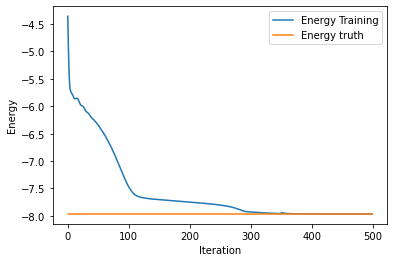

In [58]:
plt.plot(energy_list)
plt.plot([0,499], [E_truth, E_truth])
plt.legend(["Energy Training", "Energy truth"])
plt.xlabel("Iteration")
plt.ylabel("Energy")

In [59]:
n = 4
d = 2**n
np.random.seed(42)
hamiltonian = random_hamiltonian(d)
eig,_ = np.linalg.eigh(hamiltonian)
E_truth = np.min(eig)
print(f"Energy truth: {E_truth}")

rbm = RBM(n_vis=n, n_hid=20, hamiltonian=hamiltonian)
energy_list = rbm.train(iter=500, lr=0.01)

Energy truth: -13.055371981671408


  0%|          | 0/500 [00:00<?, ?it/s]

-4.224402121666046
-5.091861342687656
-5.676289543785419
-6.043391436471785
-6.30036488279595
-6.508586205410802
-6.685052268121294
-6.830799903384138
-6.946722606827224
-7.035356945890332
-7.098192229152518
-7.137670071751339
-7.161799911731569
-7.182752195277587
-7.210656315740243
-7.250953194016382
-7.3060090382967875
-7.375756364478897
-7.456474423956621
-7.540628188726913
-7.618761307007135
-7.682312216303873
-7.7261664919537205
-7.7502726410950995
-7.75989287494496
-7.7642080405167855
-7.773368369095862
-7.79486782220802
-7.830863410954306
-7.877739054984831
-7.927990427276966
-7.973572583323644
-8.009442058876921
-8.0357547835725
-8.057371865774083
-8.080721491336792
-8.110063850341861
-8.145669984049674
-8.184691249651513
-8.223492125834799
-8.259643951171661
-8.292577229448757
-8.323100234306004
-8.352615982591995
-8.382599443478977
-8.414323370284771
-8.44861229042154
-8.485591056097881
-8.52460634627413
-8.564476727308502
-8.604007604372082
-8.642506650627006
-8.680017492468

Text(0, 0.5, 'Energy')

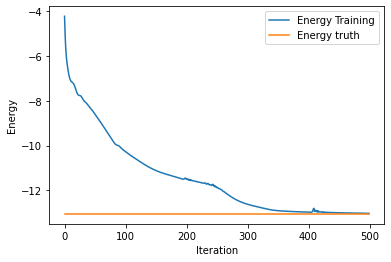

In [61]:
plt.plot(energy_list)
plt.plot([0,499], [E_truth, E_truth])
plt.legend(["Energy Training", "Energy truth"])
plt.xlabel("Iteration")
plt.ylabel("Energy")

In [65]:
n = 5
d = 2**n
np.random.seed(42)
hamiltonian = random_hamiltonian(d)
eig,_ = np.linalg.eigh(hamiltonian)
E_truth = np.min(eig)
print(f"Energy truth: {E_truth}")

rbm = RBM(n_vis=n, n_hid=20, hamiltonian=hamiltonian)
energy_list = rbm.train(iter=500, lr=0.01)

Energy truth: -21.12676076644112


  0%|          | 0/500 [00:00<?, ?it/s]

3.6015310661683824
3.2213631493210593
2.6127487346496587
1.6030180376405732
0.2807619902158367
-0.26953747609939976
0.46640647107515926
0.5645005329507057
0.3453831747627678
0.06695912791330105
-0.17185645000737568
-0.3114652625221499
-0.3304593183577005
-0.2737940200896562
-0.22313160459930945
-0.22125570193103952
-0.2627778840960605
-0.32548369069611954
-0.39256744176019415
-0.4556237945314721
-0.5097184025738764
-0.5559410792512504
-0.6057805494445099
-0.6788269723867182
-0.7948788702494216
-0.9674850379125501
-1.2062265434209931
-1.5201703659831494
-1.903750523815639
-2.317152304600945
-2.6685272578177264
-2.785960055864923
-2.614625648731262
-2.3928881820247074
-2.3153943819642615
-2.4052903909399466
-2.5912817514620636
-2.7653500265717086
-2.8166697577800224
-2.7386022242885906
-2.638189250899116
-2.602870041338491
-2.6523512028227767
-2.753124992431542
-2.849751428905302
-2.896788815729836
-2.883216622817184
-2.8368643661423785
-2.7938680439892587
-2.7778846773994874
-2.79585737

Text(0, 0.5, 'Energy')

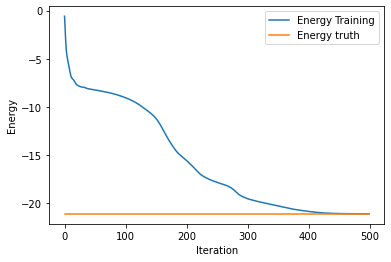

In [63]:
plt.plot(energy_list)
plt.plot([0,499], [E_truth, E_truth])
plt.legend(["Energy Training", "Energy truth"])
plt.xlabel("Iteration")
plt.ylabel("Energy")